### Import Libraries, declare variables

In [1]:
import os
import re
import google
from google.oauth2 import credentials
from google.oauth2 import service_account
from google.oauth2.service_account import Credentials
from datetime import date
from datetime import timedelta
from dateutil.relativedelta import relativedelta

# build model
import xgboost as xgb
from sklearn.metrics import roc_auc_score

SERVICE_TYPE = 'tos_cross_sell'
DATASET_ID = 'tos_cross_sell'
PROJECT_ID = 'divg-josh-pr-d1cc3a' #mapping['PROJECT_ID']
RESOURCE_BUCKET = 'divg-josh-pr-d1cc3a-default' #mapping['resources_bucket']
FILE_BUCKET = 'divg-josh-pr-d1cc3a-default' #mapping['gcs_csv_bucket']
REGION = 'northamerica-northeast1' #mapping['REGION']
MODEL_ID = '5060'
FOLDER_NAME = 'xgb_tos_cross_sell_train_deploy'.format(MODEL_ID)
QUERIES_PATH = 'vertex_pipelines/' + FOLDER_NAME + '/queries/'

scoringDate = date(2022, 9, 1)  # date.today() - relativedelta(days=2)- relativedelta(months=30)
valScoringDate = date(2022, 12, 1)  # scoringDate - relativedelta(days=2)

# training views
CONSL_VIEW_NAME = '{}_pipeline_consl_data_training_bi_layer'.format(SERVICE_TYPE)  # done
FFH_BILLING_VIEW_NAME = '{}_pipeline_ffh_billing_data_training_bi_layer'.format(SERVICE_TYPE)  # done
HS_USAGE_VIEW_NAME = '{}_pipeline_hs_usage_data_training_bi_layer'.format(SERVICE_TYPE)  # done
DEMO_INCOME_VIEW_NAME = '{}_pipeline_demo_income_data_training_bi_layer'.format(SERVICE_TYPE)  # done
PROMO_EXPIRY_VIEW_NAME = '{}_pipeline_promo_expiry_data_training_bi_layer'.format(SERVICE_TYPE)  # done
TROUBLE_TICKETS_VIEW_NAME = '{}_pipeline_trouble_tickets_data_training_bi_layer'.format(SERVICE_TYPE)  # done
GPON_COPPER_VIEW_NAME = '{}_pipeline_gpon_copper_data_training_bi_layer'.format(SERVICE_TYPE)  # done
CALL_DATA_VIEW_NAME = '{}_pipeline_call_data_training_bi_layer'.format(SERVICE_TYPE)  # done
HSIA_DROPS_VIEW_NAME = '{}_pipeline_hsia_drops_training_bi_layer'.format(SERVICE_TYPE)
CLCKSTRM_TELUS_VIEW_NAME = '{}_pipeline_clckstrm_telus_training_bi_layer'.format(SERVICE_TYPE)
TOS_ACTIVE_BANS_VIEW_NAME = '{}_pipeline_tos_active_bans_training_bi_layer'.format(SERVICE_TYPE) 

# validation views
CONSL_VIEW_VALIDATION_NAME = '{}_pipeline_consl_data_validation_bi_layer'.format(SERVICE_TYPE)
FFH_BILLING_VIEW_VALIDATION_NAME = '{}_pipeline_ffh_billing_data_validation_bi_layer'.format(SERVICE_TYPE)
HS_USAGE_VIEW_VALIDATION_NAME = '{}_pipeline_hs_usage_data_validation_bi_layer'.format(SERVICE_TYPE)
DEMO_INCOME_VIEW_VALIDATION_NAME = '{}_pipeline_demo_income_data_validation_bi_layer'.format(SERVICE_TYPE)
PROMO_EXPIRY_VIEW_VALIDATION_NAME = '{}_pipeline_promo_expiry_data_validation_bi_layer'.format(SERVICE_TYPE)
TROUBLE_TICKETS_VIEW_VALIDATION_NAME = '{}_pipeline_trouble_tickets_data_validation_bi_layer'.format(SERVICE_TYPE)
GPON_COPPER_VIEW_VALIDATION_NAME = '{}_pipeline_gpon_copper_data_validation_bi_layer'.format(SERVICE_TYPE)
CALL_DATA_VIEW_VALIDATION_NAME = '{}_pipeline_call_data_validation_bi_layer'.format(SERVICE_TYPE)
HSIA_DROPS_VIEW_VALIDATION_NAME = '{}_pipeline_hsia_drops_validation_bi_layer'.format(SERVICE_TYPE)
CLCKSTRM_TELUS_VIEW_VALIDATION_NAME = '{}_pipeline_clckstrm_telus_validation_bi_layer'.format(SERVICE_TYPE)
TOS_ACTIVE_BANS_VALIDATION_VIEW_NAME = '{}_pipeline_tos_active_bans_validation_bi_layer'.format(SERVICE_TYPE) 

# training dates
SCORE_DATE = scoringDate.strftime('%Y%m%d')  # date.today().strftime('%Y%m%d')
SCORE_DATE_DASH = scoringDate.strftime('%Y-%m-%d')
SCORE_DATE_MINUS_6_MOS_DASH = ((scoringDate - relativedelta(months=6)).replace(day=1)).strftime('%Y-%m-%d')
SCORE_DATE_LAST_MONTH_START_DASH = (scoringDate.replace(day=1) - timedelta(days=1)).replace(day=1).strftime('%Y-%m-%d')
SCORE_DATE_LAST_MONTH_END_DASH = ((scoringDate.replace(day=1)) - timedelta(days=1)).strftime('%Y-%m-%d')
SCORE_DATE_LAST_MONTH_YEAR = ((scoringDate.replace(day=1)) - timedelta(days=1)).year
SCORE_DATE_LAST_MONTH_MONTH = ((scoringDate.replace(day=1)) - timedelta(days=1)).month

# validation dates
SCORE_DATE_VAL = valScoringDate.strftime('%Y%m%d')
SCORE_DATE_VAL_DASH = valScoringDate.strftime('%Y-%m-%d')
SCORE_DATE_VAL_MINUS_6_MOS_DASH = ((valScoringDate - relativedelta(months=6)).replace(day=1)).strftime('%Y-%m-%d')
SCORE_DATE_VAL_LAST_MONTH_START_DASH = (valScoringDate.replace(day=1) - timedelta(days=1)).replace(day=1).strftime('%Y-%m-%d')
SCORE_DATE_VAL_LAST_MONTH_END_DASH = ((valScoringDate.replace(day=1)) - timedelta(days=1)).strftime('%Y-%m-%d')
SCORE_DATE_VAL_LAST_MONTH_YEAR = ((valScoringDate.replace(day=1)) - timedelta(days=1)).year
SCORE_DATE_VAL_LAST_MONTH_MONTH = ((valScoringDate.replace(day=1)) - timedelta(days=1)).month

SCORE_DATE_DELTA = 0
SCORE_DATE_VAL_DELTA = 0
TICKET_DATE_WINDOW = 30  # Days of ticket data to be queried

ACCOUNT_CONSL_QUERY_PATH = QUERIES_PATH + 'create_input_account_consl_query.txt'
ACCOUNT_HSIA_DROPS_QUERY_PATH = QUERIES_PATH + 'create_input_account_hsia_drops_query.txt'
ACCOUNT_CALL_DATA_QUERY_PATH = QUERIES_PATH + 'create_input_account_call_data_query.txt'
ACCOUNT_GPON_COPPER_QUERY_PATH = QUERIES_PATH + 'create_input_account_gpon_copper_query.txt'
ACCOUNT_TROUBLE_TICKETS_QUERY_PATH = QUERIES_PATH + 'create_input_account_trouble_tickets_query.txt'
ACCOUNT_PROMO_EXPIRY_QUERY_PATH = QUERIES_PATH + 'create_input_account_promo_expiry_query.txt'
# ACCOUNT_TV_USAGE_QUERY_PATH = QUERIES_PATH + 'create_input_account_tv_usage_query.txt'
ACCOUNT_DEMO_INCOME_QUERY_PATH = QUERIES_PATH + 'create_input_account_demo_income_query.txt'
ACCOUNT_HS_USAGE_QUERY_PATH = QUERIES_PATH + 'create_input_account_hs_usage_query.txt'
ACCOUNT_FFH_BILLING_QUERY_PATH = QUERIES_PATH + 'create_input_account_ffh_billing_query.txt'
ACCOUNT_CLCKSTRM_TELUS_QUERY_PATH = QUERIES_PATH + 'create_input_account_clckstrm_telus_query.txt'
ACCOUNT_TOS_ACTIVE_BANS_QUERY_PATH = QUERIES_PATH + 'create_input_account_tos_active_bans_query.txt'


### define get_lift function, import df_train and df_test from gcs bucket

In [2]:
import gc
import time
import pandas as pd
import numpy as np
import pickle
from google.cloud import storage
from google.cloud import bigquery
from sklearn.model_selection import train_test_split

project_id = PROJECT_ID
region = REGION
resource_bucket = RESOURCE_BUCKET
file_bucket = FILE_BUCKET
service_type=SERVICE_TYPE
score_date_dash=SCORE_DATE_DASH
score_date_val_dash=SCORE_DATE_VAL_DASH
project_id=PROJECT_ID
dataset_id=DATASET_ID

def get_lift(prob, y_test, q):
    result = pd.DataFrame(columns=['Prob', 'Churn'])
    result['Prob'] = prob
    result['Churn'] = y_test
    # result['Decile'] = pd.qcut(1-result['Prob'], 10, labels = False)
    result['Decile'] = pd.qcut(result['Prob'], q, labels=[i for i in range(q, 0, -1)])
    add = pd.DataFrame(result.groupby('Decile')['Churn'].mean()).reset_index()
    add.columns = ['Decile', 'avg_real_churn_rate']
    result = result.merge(add, on='Decile', how='left')
    result.sort_values('Decile', ascending=True, inplace=True)
    lg = pd.DataFrame(result.groupby('Decile')['Prob'].mean()).reset_index()
    lg.columns = ['Decile', 'avg_model_pred_churn_rate']
    lg.sort_values('Decile', ascending=False, inplace=True)
    lg['avg_churn_rate_total'] = result['Churn'].mean()
    lg = lg.merge(add, on='Decile', how='left')
    lg['lift'] = lg['avg_real_churn_rate'] / lg['avg_churn_rate_total']

    return lg

df_train = pd.read_csv('gs://{}/{}/{}_train.csv.gz'.format(file_bucket, service_type, service_type),
                       compression='gzip')  # for 2022-08-01
df_test = pd.read_csv('gs://{}/{}/{}_validation.csv.gz'.format(file_bucket, service_type, service_type),  # 2022-09-01
                      compression='gzip')

In [3]:
test = df_test[df_test['ban'] == 604337639]
test.head()

,ban,productMix_product_mix_all,productMix_sing_count,productMix_hsic_count,productMix_mob_count,productMix_shs_count,productMix_ttv_count,productMix_stv_count,productMix_diic_count,productMix_new_c_ind,...,infra_num_srvc_typ_gpon_sum,clckstrmData_tot_click_cnt_r30d,clckstrmData_wln_tot_cnt_r30d,clckstrmData_wln_hsic_cnt_r30d,clckstrmData_wln_tv_cnt_r30d,clckstrmData_wln_streaming_cnt_r30d,clckstrmData_wln_security_cnt_r30d,clckstrmData_wln_smarthome_security_cnt_r30d,clckstrmData_wln_online_security_cnt_r30d,clckstrmData_wln_smartwear_security_cnt_r30d


### add targets to df_train and df_target 

- df_target_train is from `divg-josh-pr-d1cc3a.tos_crosssell.bq_tos_cross_sell_targets_q3` 
- df_target_test is from `divg-josh-pr-d1cc3a.tos_crosssell.bq_tos_cross_sell_targets_q4` 
- some parts of the code and sql queries need to be dynamically adjusted to be included in the deploy model

In [4]:
def get_gcp_bqclient(project_id, use_local_credential=True):
    token = os.popen('gcloud auth print-access-token').read()
    token = re.sub(f'\n$', '', token)
    credentials = google.oauth2.credentials.Credentials(token)

    bq_client = bigquery.Client(project=project_id)
    if use_local_credential:
        bq_client = bigquery.Client(project=project_id, credentials=credentials)
    return bq_client

client = get_gcp_bqclient(project_id)

#set up df_train
sql_train = ''' SELECT * FROM `{}.{}.bq_tos_cross_sell_targets_202209` '''.format(project_id, dataset_id)
df_target_train = client.query(sql_train).to_dataframe()
df_target_train = df_target_train.loc[
    df_target_train['YEAR_MONTH'] == "2022-09"] #'-'.join(score_date_dash.split('-')[:2])]  # score_date_dash = '2022-08-31'

#set up df_train and df_test (add 'target')
df_target_train['ban'] = df_target_train['ban'].astype('int64')
df_target_train = df_target_train.groupby('ban').tail(1)

df_train = df_train.merge(df_target_train[['ban', 'product_acq_ind']], on='ban', how='left')
df_train.rename(columns={'product_acq_ind': 'target'}, inplace=True)
df_train.dropna(subset=['target'], inplace=True)
df_train['target'] = df_train['target'].astype(int)
# df_train.to_csv('gs://{}/outputs/{}_train_final.csv'.format(FILE_BUCKET, SERVICE_TYPE), index=False)

print(np.sum(df_train['target']))

client = get_gcp_bqclient(project_id)

#set up df_test
sql_test = ''' SELECT * FROM `{}.{}.bq_tos_cross_sell_targets_202212` '''.format(project_id, dataset_id)
df_target_test = client.query(sql_test).to_dataframe()
df_target_test = df_target_test.loc[
    df_target_test['YEAR_MONTH'] == "2022-12"] #'-'.join(score_date_val_dash.split('-')[:2])]  # score_date_dash = '2022-09-30'

#set up df_train and df_test (add 'target')
df_target_test['ban'] = df_target_test['ban'].astype('int64')
df_target_test = df_target_test.groupby('ban').tail(1)

df_test = df_test.merge(df_target_test[['ban', 'product_acq_ind']], on='ban', how='left')
df_test.rename(columns={'product_acq_ind': 'target'}, inplace=True)
df_test.dropna(subset=['target'], inplace=True)
df_test['target'] = df_test['target'].astype(int)
# df_test.to_csv('gs://{}/outputs/{}_test_final.csv'.format(FILE_BUCKET, SERVICE_TYPE), index=False)

print(np.sum(df_test['target']))

#set up features (list)
cols_1 = df_train.columns.values
cols_2 = df_test.columns.values
cols = set(cols_1).intersection(set(cols_2))
features = [f for f in cols if f not in ['ban', 'target']]

# #train test split
# df_train, df_val = train_test_split(df_train, shuffle=True, test_size=0.2, random_state=42,
#                                     stratify=df_train['target']
#                                     )

ban_train = df_train['ban']
X_train = df_train[features]
y_train = np.squeeze(df_train['target'].values)
target_train = df_train['target']

# ban_val = df_val['ban']
# X_val = df_val[features]
# y_val = np.squeeze(df_val['target'].values)
# target_val = df_val['target']

ban_test = df_test['ban']
X_test = df_test[features]
y_test = np.squeeze(df_test['target'].values)
target_test = df_test['target']

# del df_train, df_val, df_test
# del df_train, df_test
# gc.collect()


11222
10544


### fit training data in xgboost classifier

In [ ]:

# build model and fit in training data
import xgboost as xgb
from sklearn.metrics import roc_auc_score

xgb_model = xgb.XGBClassifier(
    learning_rate=0.01,
    n_estimators=100,
    max_depth=8,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1
    # seed=27
)

xgb_model.fit(X_train, y_train)
print('xgb training done')


In [ ]:

# build model and fit in training data
import xgboost as xgb
from sklearn.metrics import roc_auc_score

xgb_model = xgb.XGBClassifier(
    learning_rate=0.02,
    n_estimators=1000,
    max_depth=10,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

xgb_model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_test, y_test)], 
            early_stopping_rounds=20) 

print('xgb training done')


### fit training data in random forest classifier

In [5]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Create the random forest model and fit to the training data
rfc = RandomForestClassifier(n_estimators=75, max_features=8, max_depth=9)

rfc.fit(X_train, y_train)


RandomForestClassifier(max_depth=9, max_features=8, n_estimators=75)

### make predictions on validation set and get auc score

In [ ]:
#predictions on X_val
y_pred = xgb_model.predict_proba(X_val, ntree_limit=xgb_model.best_iteration)[:, 1]
y_pred_label = (y_pred > 0.5).astype(int)
auc = roc_auc_score(y_val, y_pred_label)
print(f'auc score is {auc}')
# metrics.log_metric("AUC", auc)


### make predictions on X_test set, assign deciles to the predicted values, and save in df_test_exp (RFC)

In [6]:
from sklearn.preprocessing import normalize

#predictions on X_test
pred_prb = rfc.predict_proba(X_test)[:, 1]
pred_prb = np.array(normalize([pred_prb]))[0]

#join ban_test, X_test, y_test and pred_prb and print to csv
#CHECK THE SIZE OF EACH COMPONENT BEFORE JOINING
q=10
df_ban_test = ban_test.to_frame()
df_test_exp = df_ban_test.join(X_test) 
df_test_exp['y_test'] = y_test
df_test_exp['y_pred_proba'] = pred_prb
df_test_exp['y_pred'] = (df_test_exp['y_pred_proba'] > 0.5).astype(int)
df_test_exp['decile'] = pd.qcut(df_test_exp['y_pred_proba'], q, labels=[i for i in range(q, 0, -1)])

lg = get_lift(pred_prb, y_test, q)

lg

,Decile,avg_model_pred_churn_rate,avg_churn_rate_total,avg_real_churn_rate,lift
0,1,0.000843,0.005425,0.018512,3.412353
1,2,0.000436,0.005425,0.008531,1.572460
2,3,0.000345,0.005425,0.006231,1.148522
3,4,0.000292,0.005425,0.004780,0.881071
4,5,0.000261,0.005425,0.004070,0.750190
5,6,0.000228,0.005425,0.003653,0.673369
6,7,0.000201,0.005425,0.003355,0.618362
7,8,0.000177,0.005425,0.002686,0.495069
8,9,0.000129,0.005425,0.001755,0.323464
9,10,0.000060,0.005425,0.000679,0.125167


### make predictions on X_train set, assign deciles to the predicted values, and save in df_train_exp (RFC)

In [7]:
from sklearn.preprocessing import normalize

#predictions on X_test
pred_prb = rfc.predict_proba(X_train)[:, 1]
pred_prb = np.array(normalize([pred_prb]))[0]

#join ban_test, X_test, y_test and pred_prb and print to csv
#CHECK THE SIZE OF EACH COMPONENT BEFORE JOINING
q=10
df_ban_train = ban_train.to_frame()
df_train_exp = df_ban_train.join(X_train) 
df_train_exp['y_test'] = y_train
df_train_exp['y_pred_proba'] = pred_prb
df_train_exp['y_pred'] = (df_train_exp['y_pred_proba'] > 0.5).astype(int)
df_train_exp['decile'] = pd.qcut(df_train_exp['y_pred_proba'], q, labels=[i for i in range(q, 0, -1)])

lg = get_lift(pred_prb, y_train, q)

lg

,Decile,avg_model_pred_churn_rate,avg_churn_rate_total,avg_real_churn_rate,lift
0,1,0.000859,0.005786,0.024255,4.191753
1,2,0.000459,0.005786,0.007446,1.286761
2,3,0.000365,0.005786,0.005553,0.959724
3,4,0.000312,0.005786,0.004924,0.851004
4,5,0.000280,0.005786,0.004254,0.735165
5,6,0.000244,0.005786,0.003676,0.635360
6,7,0.000216,0.005786,0.003084,0.532897
7,8,0.000191,0.005786,0.002465,0.425937
8,9,0.000136,0.005786,0.001440,0.248795
9,10,0.000064,0.005786,0.000768,0.132681


### Get Feature Importance


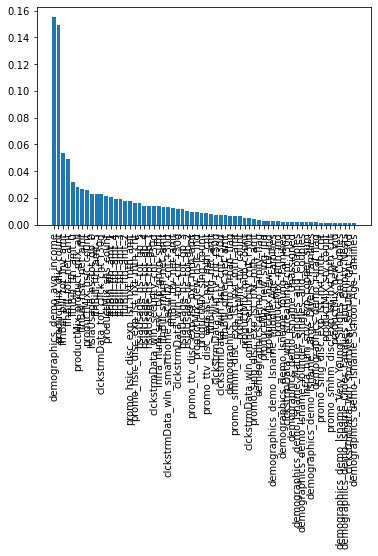

<Figure size 7200x720 with 0 Axes>

('demographics_demo_avg_income', 0.15492760452848037)
('productMix_diic_count', 0.14924969322855788)
('ffhBill_bill_tot_inv_amt', 0.05379937975473491)
('ffhBill_tot_net_amt', 0.049131037330776034)
('ffhBill_ffh_amt_0', 0.0318913368143521)
('productMix_product_mix_all', 0.02786251608692134)
('ffhBill_hsic_net_amt', 0.026344692859142614)
('productMix_hsic_count', 0.025474806647884755)
('hsiaUsage_hs_tot_gb_0', 0.023102120140434692)
('ffhBill_ffh_amt_5', 0.02303809878251083)
('clckstrmData_tot_click_cnt_r30d', 0.023006925434659445)
('productMix_shs_count', 0.021571120018289782)
('ffhBill_ffh_amt_1', 0.020267745859013125)
('ffhBill_ffh_amt_4', 0.01920635321286566)
('ffhBill_ffh_amt_3', 0.01876563892628934)
('ffhBill_ffh_amt_2', 0.017516641222610325)
('promo_hsic_disc_exp_lst_nxt_mth_amt', 0.017268486528261205)
('promo_hsic_disc_exp_lst_nxt_mth_cnt', 0.016028031981906887)
('hsiaUsage_hs_tot_gb_5', 0.015845386302557614)
('hsiaUsage_hs_tot_gb_4', 0.014040394928109991)
('hsiaUsage_hs_tot_gb_1'

In [10]:
import matplotlib.pyplot as plt

# Get feature importances from our random forest model
importances = rfc.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

feature_names = X_train.columns

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.rcParams["figure.figsize"] = (15,10)
plt.xticks(rotation=90)
plt.figure(figsize=(100, 10))
plt.show()

lst_imp = (list(zip(labels, importances[sorted_index]))) 

for item in lst_imp: 
    print(item)

### make predictions on X_test set, assign deciles to the predicted values, and save in df_test_exp

In [ ]:
from sklearn.preprocessing import normalize

#predictions on X_test
pred_prb = xgb_model.predict_proba(X_test, ntree_limit=xgb_model.best_iteration)[:, 1]
pred_prb = np.array(normalize([pred_prb]))[0]

#join ban_test, X_test, y_test and pred_prb and print to csv
#CHECK THE SIZE OF EACH COMPONENT BEFORE JOINING
q=10
df_ban_test = ban_test.to_frame()
df_test_exp = df_ban_test.join(X_test) 
df_test_exp['y_test'] = y_test
df_test_exp['y_pred_proba'] = pred_prb
df_test_exp['y_pred'] = (df_test_exp['y_pred_proba'] > 0.5).astype(int)
df_test_exp['decile'] = pd.qcut(df_test_exp['y_pred_proba'], q, labels=[i for i in range(q, 0, -1)])

lg = get_lift(pred_prb, y_test, q)

lg

### export df_test_exp and lift scores to gcs bucket

In [ ]:
df_test_exp.to_csv('gs://{}/df_test_exp.csv'.format(file_bucket, index=True))
print("....df_test_exp done")

lg.to_csv('gs://{}/lift_on_scoring_data.csv'.format(file_bucket, index=False))
print("....lift_to_csv done")

### make predictions on X_train set, assign deciles to the predicted values, and save in df_train_exp

In [ ]:
from sklearn.preprocessing import normalize

#predictions on X_test
pred_prb = xgb_model.predict_proba(X_train, ntree_limit=xgb_model.best_iteration)[:, 1]
pred_prb = np.array(normalize([pred_prb]))[0]

#join ban_test, X_test, y_test and pred_prb and print to csv
#CHECK THE SIZE OF EACH COMPONENT BEFORE JOINING
q=10
df_ban_train = ban_train.to_frame()
df_train_exp = df_ban_train.join(X_train) 
df_train_exp['y_test'] = y_train
df_train_exp['y_pred_proba'] = pred_prb
df_train_exp['y_pred'] = (df_train_exp['y_pred_proba'] > 0.5).astype(int)
df_train_exp['decile'] = pd.qcut(df_train_exp['y_pred_proba'], q, labels=[i for i in range(q, 0, -1)])

lg = get_lift(pred_prb, y_train, q)

lg

### export df_test_exp and lift scores to gcs bucket

In [ ]:
df_train_exp.to_csv('gs://{}/df_train_exp.csv'.format(file_bucket, index=True))
print("....df_train_exp done")

lg.to_csv('gs://{}/lift_on_training_data_.csv'.format(file_bucket, index=False))
print("....lift_to_csv done")

In [ ]:
import seaborn as sns
import matplotlib.pyplot

# Create the correlation matrix
corr = df_train.corr()

# Create the cmap 


# Draw the heatmap
sns.heatmap(corr,  cmap=cmap, center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()

### save the model in gcs

In [ ]:
# save the model in GCS
from datetime import datetime
models_dict = {}
create_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
models_dict['create_time'] = create_time
models_dict['model'] = xgb_model
models_dict['features'] = features

with open('model_dict.pkl', 'wb') as handle:
    pickle.dump(models_dict, handle)
handle.close()

storage_client = storage.Client()
bucket = storage_client.get_bucket(file_bucket)

MODEL_PATH = '{}_xgb_models/'.format(service_type)
blob = bucket.blob(MODEL_PATH)
if not blob.exists(storage_client):
    blob.upload_from_string('')

model_name_onbkt = '{}{}_models_xgb_{}'.format(MODEL_PATH, service_type, models_dict['create_time'])
blob = bucket.blob(model_name_onbkt)
blob.upload_from_filename('model_dict.pkl')

print(f"....model loaded to GCS done at {str(create_time)}")

time.sleep(60)

### get feature importances from xgboost model

In [ ]:
# Get feature importances from xgboost model
importances = xgb_model.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

feature_names = X_train.columns

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
importances = np.array(importances)[sorted_index]

In [ ]:
for idx, item in enumerate(labels): 
    print(labels[idx], importances[idx])

In [ ]:
importances

In [ ]:
np.argsort(importances)[::-1]

### Plotting the ROC Curve

In [ ]:
from sklearn.metrics import roc_curve 
import seaborn as sns
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, pred_prb) 
plt.plot([0, 1], [0, 1], 'k--') 
plt.plot(fpr, tpr) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('XGBoost ROC Curve') 
plt.show()

In [ ]:
pred_prb

In [ ]:
thresholds.shape

In [ ]:
y_test.shape

### load the latest saved xgb_model to the environment

In [ ]:
# MODEL_PATH = '{}_xgb_models/'.format(service_type)
# df_score = pd.read_csv('gs://{}/{}_score.csv.gz'.format(file_bucket, service_type), compression='gzip')
# df_score.dropna(subset=['ban'], inplace=True)
# df_score.reset_index(drop=True, inplace=True)
# print('......scoring data loaded:{}'.format(df_score.shape))
# time.sleep(10)
from google.cloud import bigquery
from google.cloud import storage

MODEL_PATH = '{}_xgb_models/'.format(service_type)

def load_model(file_bucket: str, service_type: str): 
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(file_bucket)
    blobs = storage_client.list_blobs(file_bucket, prefix='{}{}_models_xgb_'.format(MODEL_PATH, service_type))

    model_lists = []
    for blob in blobs:
        model_lists.append(blob.name)

    blob = bucket.blob(model_lists[-1])
    blob_in = blob.download_as_string()
    model_dict = pickle.loads(blob_in)
    xgb_model = model_dict['model']
    features = model_dict['features']
    print('...... model loaded')
    time.sleep(10)
    
    return xgb_model, features

xgb_model, features = load_model(file_bucket = FILE_BUCKET, service_type = SERVICE_TYPE)

### backup codes 

In [ ]:
def get_gcp_bqclient(project_id, use_local_credential=True):
    token = os.popen('gcloud auth print-access-token').read()
    token = re.sub(f'\n$', '', token)
    credentials = google.oauth2.credentials.Credentials(token)

    bq_client = bigquery.Client(project=project_id)
    if use_local_credential:
        bq_client = bigquery.Client(project=project_id, credentials=credentials)
    return bq_client

client = get_gcp_bqclient(project_id)

#instantiate df_target_train and df_target_test
sql_train = ''' SELECT * FROM `{}.{}.bq_tos_cross_sell_targets_q3` '''.format(project_id, dataset_id)
df_target_train = client.query(sql_train).to_dataframe()
df_target_train = df_target_train.loc[
    df_target_train['YEAR_MONTH'] == "2022-Q3"] #'-'.join(score_date_dash.split('-')[:2])]  # score_date_dash = '2022-08-31'

#set up df_train and df_test (add 'target')
df_target_train['ban'] = df_target_train['ban'].astype('int64')
df_target_train = df_target_train.groupby('ban').tail(1)

df_train = df_train.merge(df_target_train[['ban', 'product_crosssell_ind']], on='ban', how='left')
df_train.rename(columns={'product_crosssell_ind': 'target'}, inplace=True)
df_train.dropna(subset=['target'], inplace=True)
df_train['target'] = df_train['target'].astype(int)

df_train

In [ ]:
sum(df_train['target'])

In [ ]:
def get_gcp_bqclient(project_id, use_local_credential=True):
    token = os.popen('gcloud auth print-access-token').read()
    token = re.sub(f'\n$', '', token)
    credentials = google.oauth2.credentials.Credentials(token)

    bq_client = bigquery.Client(project=project_id)
    if use_local_credential:
        bq_client = bigquery.Client(project=project_id, credentials=credentials)
    return bq_client

client = get_gcp_bqclient(project_id)
sql_test = ''' SELECT * FROM `{}.{}.bq_tos_cross_sell_targets_q4` '''.format(project_id, dataset_id)
df_target_test = client.query(sql_test).to_dataframe()
df_target_test = df_target_test.loc[
    df_target_test['YEAR_MONTH'] == "2022-Q4"] #'-'.join(score_date_val_dash.split('-')[:2])]  # score_date_dash = '2022-09-30'

#set up df_train and df_test (add 'target')
df_target_test['ban'] = df_target_test['ban'].astype('int64')
df_target_test = df_target_test.groupby('ban').tail(1)

df_test = df_test.merge(df_target_test[['ban', 'product_crosssell_ind']], on='ban', how='left')
df_test.rename(columns={'product_crosssell_ind': 'target'}, inplace=True)
df_test.dropna(subset=['target'], inplace=True)
df_test['target'] = df_test['target'].astype(int)

df_test

In [ ]:
sum(df_test['target'])